# Chain

Review - We built a simple graph with nodes, normal edges and conditional edges.

Goals Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state Using chat models in graph nodes Binding tools to our chat model Executing tool calls in graph nodes.

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [4]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="gemma2-9b-it")
result=llm.invoke(messages)
result

AIMessage(content="That's a fantastic choice! Orcas, also known as killer whales, are truly magnificent creatures.  \n\nFor the best chance of seeing orcas in the US, you have a few top contenders:\n\n* **Washington State:**  Specifically, the waters around **San Juan Island** and **Whidbey Island** are renowned for their orca populations. These waters are home to the resident orcas, known for their complex social structures and distinct family groups.  You can join whale watching tours that are specifically designed to spot these incredible animals.\n\n* **Alaska:**  The southeastern coast of Alaska, particularly around **Juneau**, **Sitka**, and **Ketchikan**, offers excellent opportunities to see orcas. \n\n* **California:**  While the numbers are lower than in Washington or Alaska, you can still see orcas off the coast of California, especially around **San Diego** and **Long Beach**.\n\n**Here are some factors to consider when choosing the best location:**\n\n* **Time of year:**  

In [5]:
def add(a:int, b:int)-> int:
    """
    Add a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a+b

In [6]:
llm_with_tools=llm.bind_tools([add])

In [7]:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mcfr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 982, 'total_tokens': 1069, 'completion_time': 0.158181818, 'prompt_time': 0.044747788, 'queue_time': 0.235615544, 'total_time': 0.202929606}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-40acc0ce-d27f-4d51-80aa-ebafcce7a6a6-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_mcfr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 982, 'output_tokens': 87, 'total_tokens': 1069})

In [8]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'call_mcfr',
  'type': 'tool_call'}]

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [10]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                HumanMessage(content="I'm looking for information on generative ai.", name="Deepak")
                ]
#New message to add
new_message= AIMessage(content="Sure, I can help with that. What specific are you interested in?", name="Model")
add_messages(initial_message, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='bf5c56e5-2959-4368-a90d-f616b191844a'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Deepak', id='d36016ed-48b1-4b36-8696-2bfb80e082b0'),
 AIMessage(content='Sure, I can help with that. What specific are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='9ab98f55-be69-49fa-bb86-e744122c975b')]

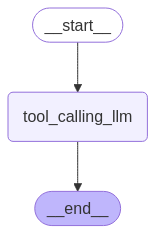

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

#Node
def tool_calling_llm(state: MessageState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages=graph.invoke({"messages":HumanMessage(content="What is 3 add 2?")})
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

What is 3 add 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_25c0)
 Call ID: call_25c0
  Args:
    a: 3
    b: 2


In [16]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

# Tools

Tools are useful whenever you want a model to interact with external systems.

External systems(e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required Input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, It will return an output that adheres to the tool's schema.

